In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def plot_rf(data, show=True, savepath=None, start_index=0, end_index=None):
    
    t = data[:,0]
    v = data[:,1]
    
    # Slice the data
    t_plot = t[start_index:end_index]
    v_plot = v[start_index:end_index]

    plt.figure(figsize=(10,6))
    plt.plot(t_plot, v_plot, '-', lw=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('RF voltage (V)')
    plt.grid(True)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    if show:
        plt.show()

    # return t_plot, v_plot


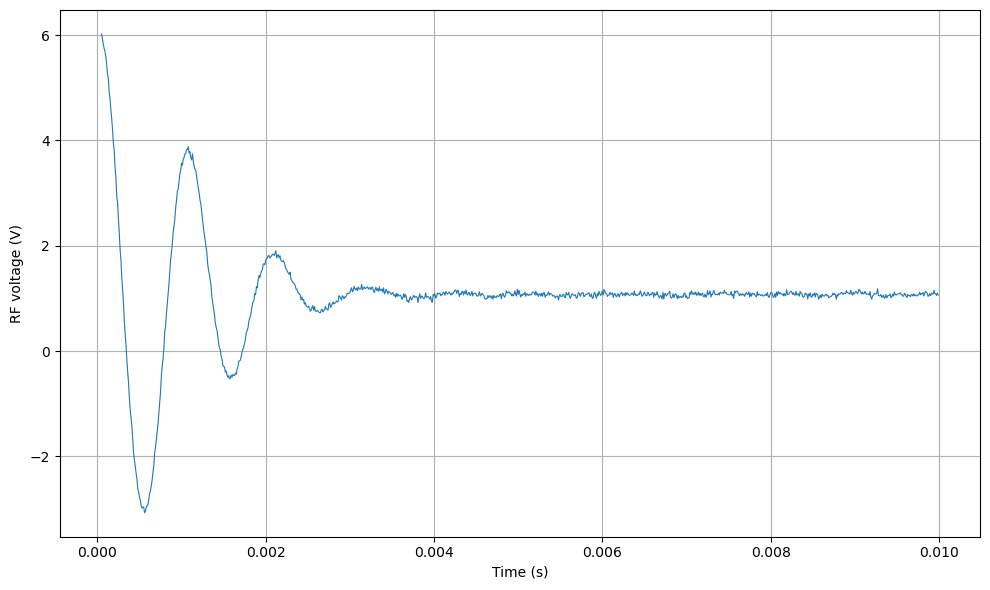

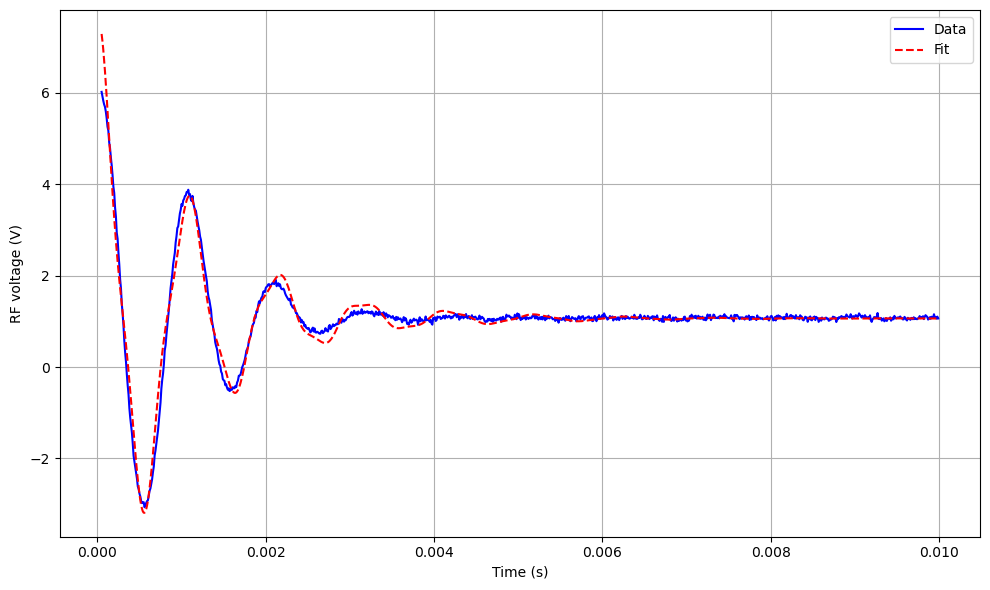

Y shift term (offset): 1.063416


In [62]:
from scipy.optimize import curve_fit

# Manual approach - specify start index
datafile = 'nutation/16_13/0.9.txt'
data = np.loadtxt(datafile)

plot_rf(data, start_index=5)

def oscillation_decay(t, A, omega, phi, gamma, omega_beat, y_offset):
  """Oscillating exponential decay function with beat envelope"""
  beat_envelope = (1 + 0.3 * np.cos(omega_beat * t))  # Beat modulation depth of 30%
  return A * np.exp(-gamma * t) * np.cos(omega * t + phi) * beat_envelope + y_offset

# Use the cleaned data cutted first 5 points
datacut = data[5:]  # Uncomment if you want to remove first 5 points
t_fit = datacut[:,0]
v_fit = datacut[:,1]

# Initial parameter guesses
p0 = [6.0, 2*np.pi/0.001, 0, 1, 2*np.pi*1, 0]  # [A, omega, phi, gamma, omega_beat, y_offset]
# p0 = [2.0, 2*np.pi/0.0001, 0, 1, 2*np.pi*100, 0]  # [A, omega, phi, gamma, omega_beat, y_offset]

# Fit the data
popt, pcov = curve_fit(oscillation_decay, t_fit, v_fit, p0=p0)

# Plot the fit
plt.figure(figsize=(10,6))
plt.plot(t_fit, v_fit, 'b-', label='Data')
plt.plot(t_fit, oscillation_decay(t_fit, *popt), 'r--', label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('RF voltage (V)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract fitted parameters
A_fit, omega_fit, phi_fit, gamma_fit, omega_beat_fit, y_offset_fit = popt

print(f"Y shift term (offset): {y_offset_fit:.6f}")


In [70]:
def analyze_nutation_data(folder_name, cutoff=5, yshift=None):
  """
  Analyze nutation data from a specified folder.
  
  Parameters:
  folder_name (str): Name of the folder containing .txt files (e.g., '16_13')
  
  Returns:
  tuple: (file_names_sorted, max_amplitudes_sorted, pulse_90, pulse_180)
  """
  # Get all .txt files in the specified directory
  txt_files = glob.glob(f'nutation/{folder_name}/*.txt')
  txt_files.sort()  # Sort to ensure consistent ordering

  # Lists to store results
  file_names = []
  max_amplitudes = []

  # Process each file
  for file_path in txt_files:
    # Load data
    data = np.loadtxt(file_path)
    
    # Remove first 5 points
    data_cut = data[cutoff:]
    
    # Extract voltage data and subtract offset
    v_corrected = data_cut[:,1] - yshift
    
    # Find maximum absolute amplitude
    max_amp = np.max(np.abs(v_corrected))
    max_amplitudes.append(max_amp)
    
    # Extract filename (without path and extension) and convert to float
    filename = os.path.basename(file_path).replace('.txt', '')
    file_names.append(float(filename))

  # Convert to numpy arrays for easier handling
  file_names = np.array(file_names)
  max_amplitudes = np.array(max_amplitudes)

  # Sort by file names (time values)
  sort_indices = np.argsort(file_names)
  file_names_sorted = file_names[sort_indices]
  max_amplitudes_sorted = max_amplitudes[sort_indices]

  # Create the plot
  plt.figure(figsize=(12, 8))
  plt.plot(file_names_sorted, max_amplitudes_sorted, 'bo-', markersize=6, linewidth=2)
  plt.xlabel('tω (microseconds)')
  plt.ylabel('Maximum Amplitude (V)')
  plt.title(f'Maximum Amplitude vs tω for Nutation Data - {folder_name}')
  plt.grid(True, alpha=0.7)
  plt.tight_layout()
  plt.show()

  # Find peaks and valleys to determine pulse lengths
  from scipy.signal import find_peaks
  peaks, _ = find_peaks(max_amplitudes_sorted, height=0.1, distance=5)
  valleys, _ = find_peaks(-max_amplitudes_sorted, height=-np.max(max_amplitudes_sorted)+0.1, distance=5)

  pulse_90 = None
  pulse_180 = None

  if len(peaks) > 0:
    pulse_90 = file_names_sorted[peaks[0]]
    print(f"90 degree pulse length: {pulse_90:.2f} μs")
  else:
    print("No peaks found for 90 degree pulse")

  if len(valleys) > 0:
    pulse_180 = file_names_sorted[valleys[0]]
    print(f"180 degree pulse length: {pulse_180:.2f} μs")
  else:
    print("No valleys found for 180 degree pulse")

  return file_names_sorted, max_amplitudes_sorted, pulse_90, pulse_180

# Example usage:
# file_names, max_amps, pulse_90, pulse_180 = analyze_nutation_data('16_13')


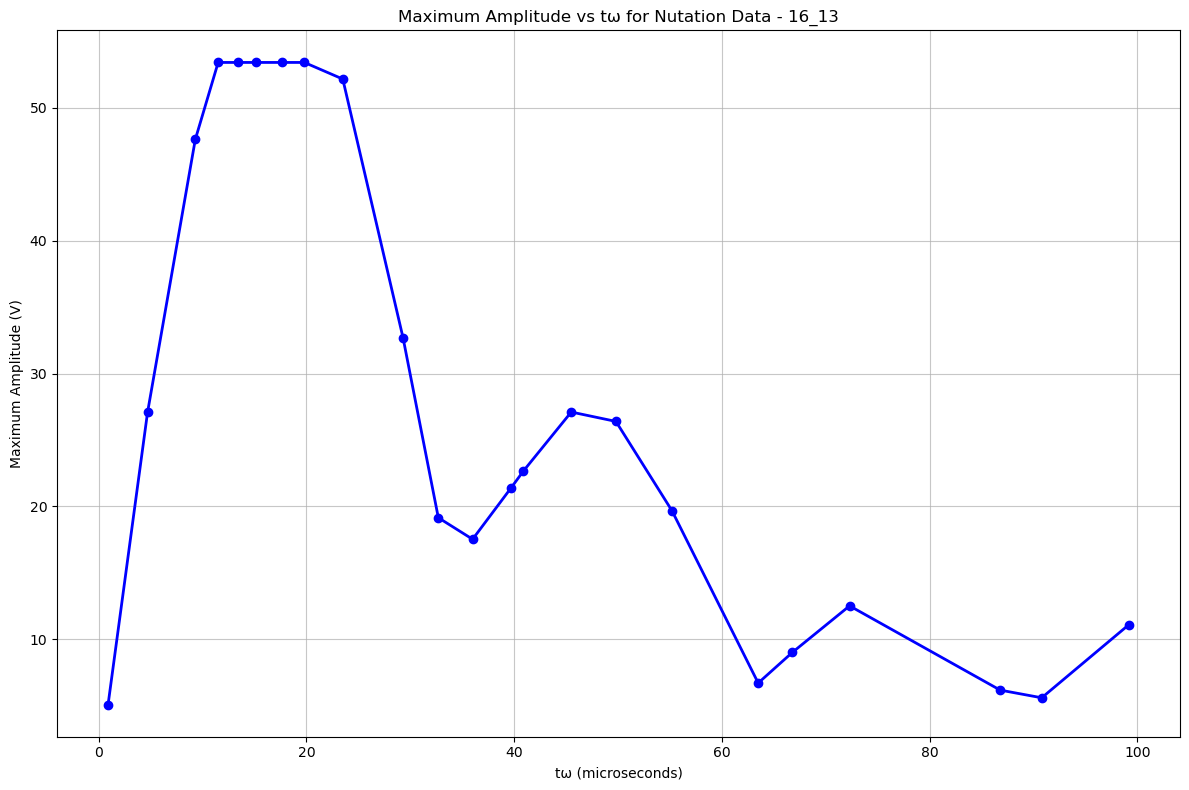

90 degree pulse length: 15.10 μs
180 degree pulse length: 36.00 μs


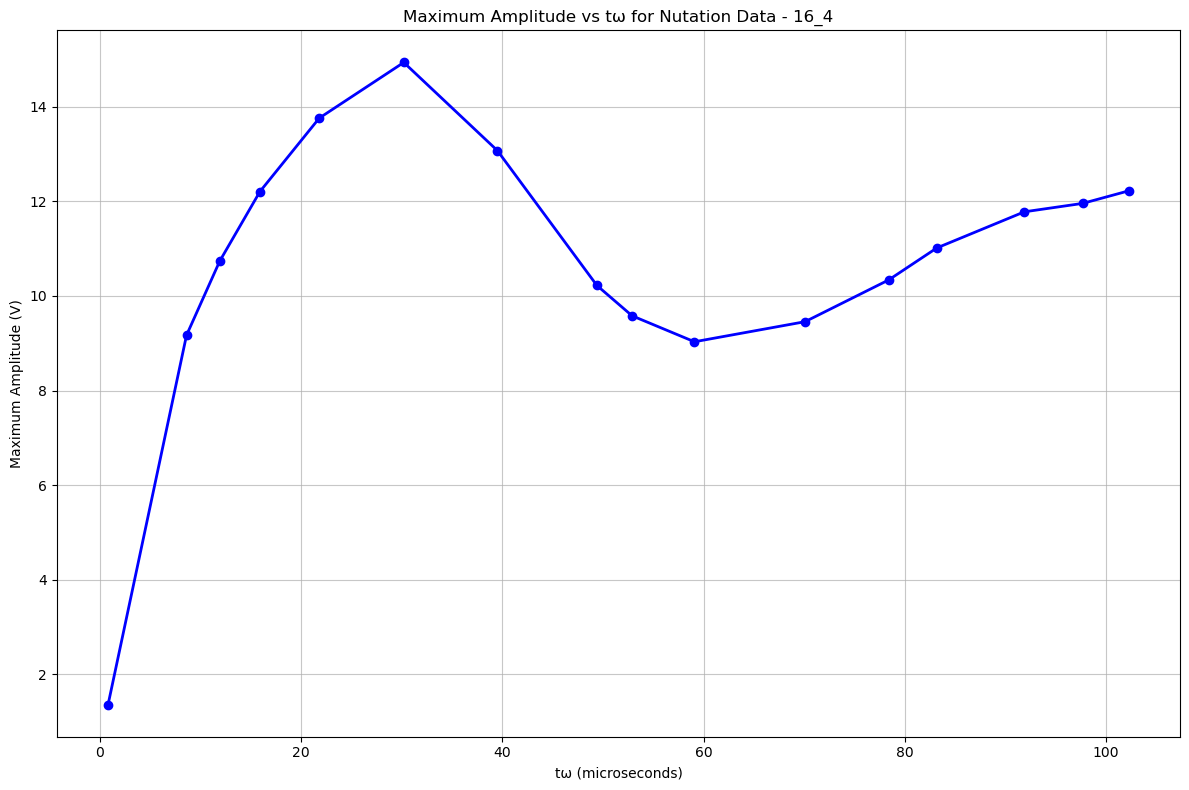

90 degree pulse length: 30.20 μs
180 degree pulse length: 59.10 μs


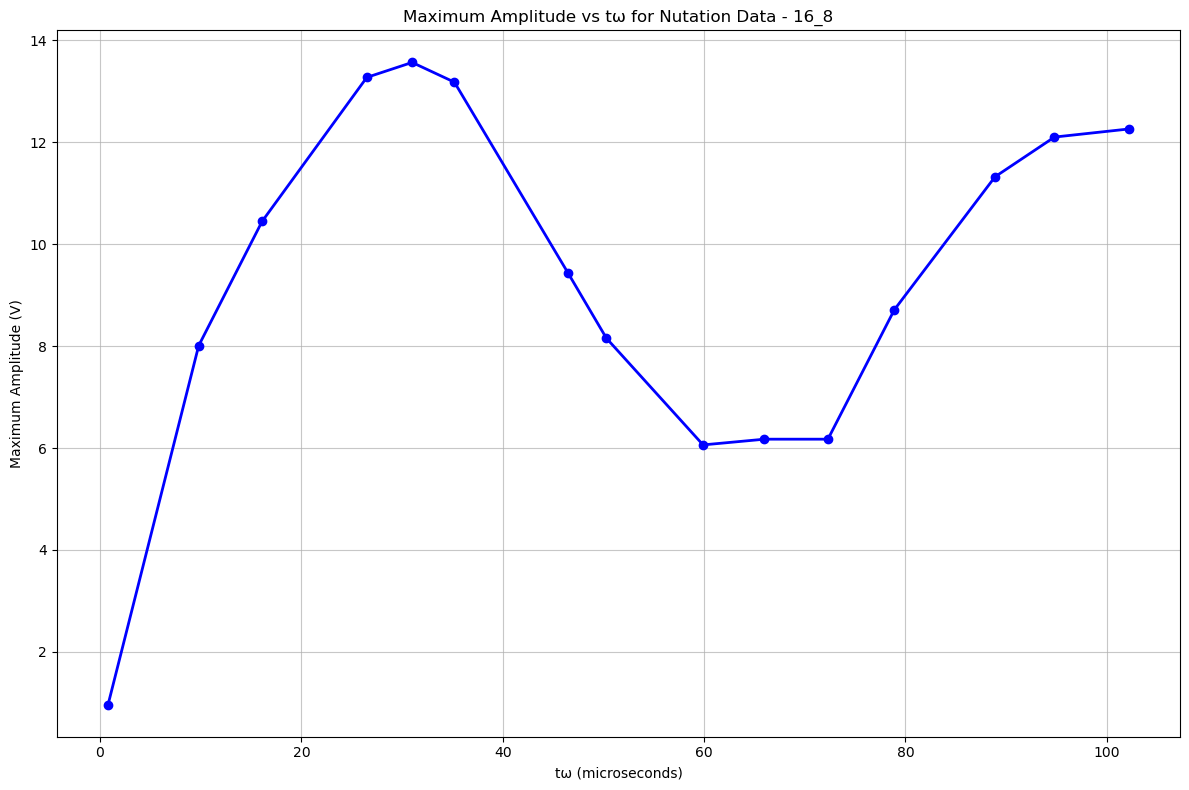

90 degree pulse length: 31.00 μs
180 degree pulse length: 59.90 μs


(array([  0.8,   9.8,  16.1,  26.5,  31. ,  35.2,  46.5,  50.3,  59.9,
         66. ,  72.3,  78.9,  88.9,  94.8, 102.2]),
 array([ 0.963428,  8.008476, 10.448575, 13.274652, 13.568004, 13.180708,
         9.430577,  8.154668,  6.06097 ,  6.173342,  6.173342,  8.714461,
        11.324022, 12.103222, 12.262319]),
 31.0,
 59.9)

In [71]:
analyze_nutation_data('16_13', cutoff = 4, yshift = 1.063416)
analyze_nutation_data('16_4', cutoff = 8, yshift = 0.558471)
analyze_nutation_data('16_8', cutoff = 8, yshift = 0.648161)